# The goal
How to deal with tweets? Start with unsupervised unclassified data. What can you learn from unstructured Twitter data? Use unsupervised learning.

Ideally, we'd like to have a broad understanding of what the tweets were about. This is called topic modeling. 
Here we will use an algorithm called Latent Dirichlet Algorithm (LDA). Some intermediate steps are data cleaning and matching heterogeneous datasets. Ultimately this will lead to a more guided data understanding

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from collections import Counter
import operator
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import Pyro4

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import seaborn as sns

/Users/Peter/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# First load the data into a pandas dataframe

In [2]:
kagTweets = pd.read_csv('kaggleTweets.csv')

In [3]:
tweets = pd.read_csv('Tweets-CustomerSupport.csv', sep=';',index_col='id')
tweets = tweets.drop_duplicates('tweetId')
tweets.columns = ['account','from_handler','to_handler','message','time_stamp','tweet_id']

In [4]:
tweets = pd.read_csv('Tweets-CustomerSupport.csv', sep=';',index_col='id')

In [5]:
#Get rid of duplicate tweets
tweets.drop_duplicates('tweetId')
tweets.head()

,account,fromHandler,toHandler,message,timestamp,tweetId
id,,,,,,
1,@1ShirtSupport,@1ShirtSupport,@PissedOffBiotic,@PissedOffBiotic You got it! Just email us you...,01/18/2016 05:09:13,688951251455754241
2,@1ShirtSupport,@1ShirtSupport,@LordEstevez,@LordEstevez Thanks for the info! Well check o...,01/18/2016 02:38:39,688913360679653376
3,@1ShirtSupport,@1ShirtSupport,@LordEstevez,@LordEstevez Just want to make sure we have al...,01/18/2016 02:15:10,688907453212184576
4,@1ShirtSupport,@1ShirtSupport,@LordEstevez,@LordEstevez found it! It actually shows up as...,01/18/2016 02:14:24,688907258206367744
5,@1ShirtSupport,@1ShirtSupport,@LightingAshley,@LightingAshley It should be just about to be ...,01/18/2016 01:39:32,688898486025060352


In [6]:
list(np.unique(tweets.account))

['@1ShirtSupport',
 '@Airbnb',
 '@AmazonHelp',
 '@AskAmex',
 '@Avis',
 '@BCBSIL',
 '@GoDaddyHelp',
 '@Hootsuite_Help',
 '@InstapaperHelp',
 '@JetBlue',
 '@Kohls',
 '@MasterCard',
 '@MicrosoftHelps',
 '@TmobileHelp',
 '@americanair',
 '@fedexhelp',
 '@nikestore',
 '@schuh',
 '@verizon']

In [7]:
def getToFromTweets(userAccount,toTweet=True):
    """Function to print the number of tweets from a given account"""
    if toTweet==True:
        toFrom = 'toHandler'
    else:
        toFrom = 'fromHandler'
    tweetNum = str(np.sum(tweets[toFrom]==userAccount))
    #tweetNum = str(np.sum(tweets['toHandler']==userAccount))
    if toTweet==True:
        print 'Tweets to %s: %s' % (userAccount, tweetNum)
    else:
        print 'Tweets from %s: %s' % (userAccount, tweetNum)

In [8]:
for i in list(np.unique(tweets.account)):
    getToFromTweets(i,False)

Tweets from @1ShirtSupport: 3204
Tweets from @Airbnb: 3202
Tweets from @AmazonHelp: 3216
Tweets from @AskAmex: 3201
Tweets from @Avis: 3219
Tweets from @BCBSIL: 3233
Tweets from @GoDaddyHelp: 3238
Tweets from @Hootsuite_Help: 3240
Tweets from @InstapaperHelp: 3229
Tweets from @JetBlue: 3200
Tweets from @Kohls: 3207
Tweets from @MasterCard: 3205
Tweets from @MicrosoftHelps: 3211
Tweets from @TmobileHelp: 0
Tweets from @americanair: 0
Tweets from @fedexhelp: 0
Tweets from @nikestore: 3204
Tweets from @schuh: 3231
Tweets from @verizon: 3243


In [65]:
for i in list(np.unique(tweets.account)):
    getToFromTweets(i,True)

Tweets to @1ShirtSupport: 532
Tweets to @Airbnb: 23
Tweets to @AmazonHelp: 2991
Tweets to @AskAmex: 43
Tweets to @Avis: 360
Tweets to @BCBSIL: 78
Tweets to @GoDaddyHelp: 526
Tweets to @Hootsuite_Help: 180
Tweets to @InstapaperHelp: 38
Tweets to @JetBlue: 75
Tweets to @Kohls: 681
Tweets to @MasterCard: 38
Tweets to @MicrosoftHelps: 653
Tweets to @TmobileHelp: 0
Tweets to @americanair: 0
Tweets to @fedexhelp: 0
Tweets to @nikestore: 6295
Tweets to @schuh: 495
Tweets to @verizon: 71


In [10]:
companyList = list(np.unique(tweets.account))
companyList.append('@TMobileHelp')
companyList.append('@AmericanAir')
companyList.append('@FedExHelp')

companyList
#list(np.unique(tweets.fromHandler))

['@1ShirtSupport',
 '@Airbnb',
 '@AmazonHelp',
 '@AskAmex',
 '@Avis',
 '@BCBSIL',
 '@GoDaddyHelp',
 '@Hootsuite_Help',
 '@InstapaperHelp',
 '@JetBlue',
 '@Kohls',
 '@MasterCard',
 '@MicrosoftHelps',
 '@TmobileHelp',
 '@americanair',
 '@fedexhelp',
 '@nikestore',
 '@schuh',
 '@verizon',
 '@TMobileHelp',
 '@AmericanAir',
 '@FedExHelp']

In [11]:
usrIdx = tweets['fromHandler'].isin(companyList)
usrTweets = tweets[~usrIdx]
compTweets = tweets[usrIdx]
#tweets[tweets['fromHandler'].isin(list(np.unique(tweets.account)))]

In [12]:
verTweets = tweets[tweets.fromHandler=='@verizon']

# Gensim code

In [13]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim import corpora, models
from gensim.similarities import MatrixSimilarity
#import os
#import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import timeit
from re import sub
import pyLDAvis.gensim
from collections import Counter
from gensim.matutils import corpus2csc, sparse2full, corpus2dense

In [14]:
#Functions for data cleaning

wnl = WordNetLemmatizer()

def removePunc(myWord):
    """Function to remove punctuation from string inputs"""
    if myWord is None:
        return myWord
    else:
        return sub('[.:;()/!&-*@$,?^\d+]','',myWord)
        
def removeAscii(myWord):
    """Function to remove ascii from string input"""
    if myWord is None:
        return myWord
    else:
        return str(sub(r'[^\x00-\x7F]+','', myWord.decode('utf-8').strip()))

def lemmatize(myWord):// 
    """Function to lemmatize words"""
    if myWord is None:
        return myWord
    else:
        return wnl.lemmatize(myWord)

def removeStopWords(myWord):
    """Function to remove stop words"""
    if myWord is None:
        return myWord
    if myWord not in str(stopwords.words('english')):
        return myWord

def removeLinkUser(myWord):
    """Function to remove web addresses and twitter handles"""
    if not myWord.startswith('@') and not myWord.startswith('http'):
        return myWord

def prepText(myWord):
    """Final text pre-processing function"""
    return removeStopWords(
        lemmatize(
            removeAscii(
                removePunc(
                    removeLinkUser(
                        myWord.lower()
                    )
                )
            )
        )
    )


In [15]:
# Function to clean/filter all tweets

def filterTweetList(tweetList):
    """Remove stop words, lemmatize, and clean all tweets"""
    return [[prepText(word) for word
                in tweet.split()
                    if prepText(word) is not None]
                for tweet in tweetList]
cleanTweetList = filterTweetList(tweets['message'])

In [16]:
%%timeit
# Using iterator:             10 loops, best of 3: 137 ms per loop
# Using double list comprhxn: 10 loops, best of 3: 141 ms per loop

# Iterator
for tweet in (tweet for tweet in verTweets['message']):
    [word.lower() for word in tweet.split() if word not in str(stopwords.words('english')) and not word.startswith('@') and not word.startswith('http')]
#[[word.lower() for word in tweet.split() if word not in stopwords.words('english') and not word.startswith('@') and not word.startswith('http')] for tweet in verTweets['message']]


1 loops, best of 3: 7.9 s per loop


### Using an iterator doesn't speed up the data cleaning

## Wanted to check the speed saved by parallelization using `%%timeit`
#### Without multicore:  
_Code_  
`lda = models.LdaMulticore(corpus, id2word=dictionary, num_topics=50, passes=10, iterations=50,alpha=0.001)`  

_`Output from %%timeit`_  
`1 loops, best of 3: 11min 10s per loop`

#### With multicore:  
_Code_  
`lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=50, passes = 10,iterations=50,alpha=0.001)`  
_`Output from %%timeit`_  
`1 loops, best of 3: 6min 17s per loop`  



# Bottom line: _multicore LDA is about twice as fast_


In [17]:
def makeDict(myTweetList):
    """Create dictionary from list of tokenized documents"""
    return corpora.Dictionary(myTweetList)

def makeCorpus(myTweetList,myDict):
    """Create corpus from list of tokenized documents"""
    return [myDict.doc2bow(tweet) for tweet in myTweetList]

def createLDA(myCorpus, myDictionary,myTopics=50,myPasses=10,myIterations=50,myAlpha=0.001):
    """LDA model call function"""
    return models.LdaMulticore(myCorpus, id2word=myDictionary, num_topics=myTopics, passes=myPasses,
    iterations=myIterations,alpha=myAlpha)

#lsi = models.LsiModel(myCorpus, id2word=myDict, num_topics=50)
# lsi has lower accuracy than lda

In [20]:
myDict = makeDict(cleanTweetList)
myCorpus = makeCorpus(cleanTweetList, myDict)
myLda = createLDA(myCorpus, myDict)

In [21]:
myLda = createLDA(myCorpus, myDict)

In [22]:
# turn on automatic rendering of visualizations
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(myLda, myCorpus, myDict)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
14     5.595332        1       1 -0.274494 -0.113857
15     3.786158        1       2 -0.240255 -0.072699
12     3.694810        1       3 -0.182217 -0.026542
22     3.580502        1       4 -0.184002 -0.011691
36     3.129671        1       5  0.039280 -0.099663
9      3.021108        1       6 -0.041636  0.133742
49     2.470785        1       7  0.045543  0.132499
8      2.439451        1       8  0.064601 -0.082027
32     2.428670        1       9 -0.034751  0.061153
6      2.366105        1      10 -0.065622  0.052902
13     2.358320        1      11 -0.160606 -0.008084
21     2.343819        1      12 -0.059936 -0.083741
23     2.274949        1      13 -0.046659  0.130969
19     2.242174        1      14 -0.157692  0.004071
33     2.164295        1      15  0.010719  0.074174
43     2.120763        1      16 -0.175237 -0.047380
45     1.964110        1      17 -0.006568 -0.028561
16     1.950132        1      18  0.080188  0.091429
37     1.918988        1      19  0.023123  0.131549
17     1.893773        1      20  0.017134 -0.121425
30     1.885861        1      21  0.050544 -0.087810
0      1.861235        1      22  0.104633  0.063159
18     1.836724        1      23 -0.042918  0.134160
29     1.836033        1      24 -0.076579  0.065639
47     1.833894        1      25  0.048129  0.135811
31     1.829512        1      26  0.059875  0.092030
40     1.796572        1      27  0.123326 -0.058601
24     1.785907        1      28  0.006851 -0.022718
38     1.771329        1      29  0.024075  0.069916
5      1.707060        1      30  0.040442  0.035510
28     1.687912        1      31 -0.043372 -0.008250
44     1.666396        1      32  0.024318  0.107634
34     1.660197        1      33  0.074612 -0.052727
20     1.632716        1      34  0.069566  0.012715
25     1.607624        1      35  0.109317 -0.124003
1      1.556829        1      36  0.093498 -0.020262
48     1.490939        1      37  0.017589 -0.081105
10     1.467162        1      38 -0.024567  0.047540
35     1.461667        1      39  0.058530  0.032698
42     1.405469        1      40  0.091379 -0.078911
4      1.402812        1      41  0.029679  0.107173
26     1.389538        1      42 -0.000646 -0.074606
39     1.339656        1      43  0.052701  0.062750
7      1.323270        1      44 -0.107160 -0.037696
11     1.218199        1      45  0.058161 -0.061112
2      1.209165        1      46  0.080153 -0.107654
3      1.208728        1      47  0.120667 -0.069983
41     1.145813        1      48  0.100196  0.020411
46     1.130666        1      49  0.077989 -0.034769
27     1.107197        1      50  0.128100 -0.183758, topic_info=      Category         Freq           Term  Total  loglift  logprob
27790  Default  5192.000000           know   5192  30.0000  30.0000
8766   Default  8128.000000             dm   8128  29.0000  29.0000
8169   Default  5271.000000            let   5271  28.0000  28.0000
7222   Default  3736.000000          happy   3736  27.0000  27.0000
26527  Default  3876.000000          check   3876  26.0000  26.0000
8375   Default  3390.000000          email   3390  25.0000  25.0000
16830  Default  4521.000000           look   4521  24.0000  24.0000
7446   Default  3373.000000           take   3373  23.0000  23.0000
7861   Default  4001.000000         number   4001  22.0000  22.0000
22807  Default  2777.000000          youre   2777  21.0000  21.0000
24917  Default  2914.000000          thank   2914  20.0000  20.0000
12524  Default  3543.000000           hear   3543  19.0000  19.0000
16694  Default  2531.000000          issue   2531  18.0000  18.0000
25481  Default  9713.000000         please   9713  17.0000  17.0000
22221  Default  2835.000000          great   2835  16.0000  16.0000
16655  Default  7335.000000           help   7335  15.0000  15.0000
24061  Default  2591.000000           need   

## Clean the data, build the dict and corpus, and call the LDA model

In [23]:
cleanUsrTweetList = filterTweetList(usrTweets['message'])
usrDict   = makeDict(cleanUsrTweetList)
usrCorpus = makeCorpus(cleanUsrTweetList, usrDict)
usrLda = createLDA(usrCorpus, usrDict)

In [24]:
pyLDAvis.gensim.prepare(usrLda, usrCorpus, usrDict)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
21     4.457284        1       1  0.182174  0.297119
44     3.351255        1       2 -0.183403  0.017234
4      2.963446        1       3  0.234330  0.112045
10     2.816679        1       4 -0.131056  0.016851
30     2.576944        1       5 -0.148528  0.113862
2      2.561979        1       6 -0.179888  0.075392
36     2.529131        1       7 -0.082036  0.053444
15     2.518006        1       8 -0.096119 -0.025349
27     2.423239        1       9 -0.124623 -0.027923
35     2.342020        1      10 -0.100906 -0.042892
48     2.329321        1      11  0.034971  0.179822
24     2.312042        1      12 -0.088737  0.074306
32     2.309990        1      13 -0.142666 -0.008277
31     2.305596        1      14 -0.167676  0.067307
14     2.200273        1      15  0.117669 -0.029518
49     2.123318        1      16 -0.071858 -0.031079
38     2.119874        1      17  0.180698  0.173558
41     2.112761        1      18  0.029395 -0.057744
17     2.096313        1      19  0.121839 -0.113951
40     2.083665        1      20 -0.098287  0.013629
23     2.073481        1      21  0.051053 -0.030875
0      2.066196        1      22  0.016850  0.051891
39     1.986986        1      23  0.000691  0.007243
43     1.953427        1      24 -0.094227 -0.015607
6      1.949984        1      25 -0.068923  0.003421
19     1.927337        1      26  0.031891 -0.033860
13     1.858934        1      27  0.117604 -0.170090
26     1.845919        1      28  0.137413 -0.011601
29     1.802140        1      29 -0.017205 -0.042412
28     1.798700        1      30 -0.075905  0.036706
42     1.787496        1      31 -0.067107 -0.023616
34     1.771653        1      32 -0.036453  0.006710
47     1.757807        1      33  0.088398 -0.094187
1      1.745506        1      34 -0.006708 -0.045549
9      1.732273        1      35  0.003926 -0.065822
5      1.728447        1      36 -0.088184 -0.013568
12     1.678025        1      37  0.152370  0.055352
25     1.608105        1      38  0.126514 -0.141273
37     1.568503        1      39 -0.020802 -0.027655
22     1.472239        1      40  0.008135 -0.030778
11     1.461273        1      41 -0.020207  0.003430
7      1.455798        1      42  0.068106  0.019889
45     1.450421        1      43  0.029322 -0.030325
16     1.387334        1      44  0.067927 -0.039663
46     1.350929        1      45  0.125533 -0.036849
3      1.313109        1      46 -0.002951 -0.029163
20     1.268914        1      47  0.039475 -0.059395
33     1.259948        1      48  0.083399 -0.044446
8      1.238462        1      49  0.046782 -0.008576
18     1.167520        1      50  0.017992 -0.047164, topic_info=      Category         Freq        Term  Total  loglift  logprob
4340   Default  1682.000000         air   1682  30.0000  30.0000
1267   Default   897.000000         one    897  29.0000  29.0000
11697  Default  1162.000000        nike   1162  28.0000  28.0000
5935   Default  1140.000000      jordan   1140  27.0000  27.0000
355    Default   675.000000     service    675  26.0000  26.0000
7473   Default   603.000000         new    603  25.0000  25.0000
7029   Default   525.000000       thank    525  24.0000  24.0000
2199   Default   528.000000        kobe    528  23.0000  23.0000
10000  Default   802.000000        back    802  22.0000  22.0000
13180  Default   509.000000       style    509  21.0000  21.0000
5771   Default   812.000000        help    812  20.0000  20.0000
1345   Default   447.000000        take    447  19.0000  19.0000
2943   Default   529.000000    customer    529  18.0000  18.0000
12960  Default   418.000000       woman    418  17.0000  17.0000
6282   Default   476.000000        game    476  16.0000  16.0000
6861   Default   567.000000        need    567  15.0000  15.0000
3948   Default   455.000000       order    455  14.0000  14.0000
238    Default   424.000000    

In [25]:
cleanCompTweetList = filterTweetList(compTweets['message'])
compDict   = makeDict(cleanCompTweetList)
compCorpus = makeCorpus(cleanCompTweetList, compDict)


In [26]:
compLda = createLDA(compCorpus, compDict)

In [27]:
pyLDAvis.gensim.prepare(compLda, compCorpus, compDict)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
9      5.679373        1       1  0.313728 -0.071310
35     4.207619        1       2  0.118462 -0.109942
0      3.465517        1       3  0.312520 -0.044167
21     3.188998        1       4  0.278646  0.055934
38     2.947807        1       5  0.074139  0.216835
31     2.863961        1       6  0.135041  0.126531
16     2.849898        1       7  0.022825  0.217351
20     2.568560        1       8  0.038914 -0.015038
27     2.527278        1       9 -0.046145 -0.004699
39     2.522209        1      10  0.209910  0.110560
28     2.513445        1      11 -0.024586  0.174796
4      2.433008        1      12  0.099585 -0.206976
3      2.423233        1      13  0.022068 -0.191652
15     2.351228        1      14  0.148757 -0.051746
33     2.264848        1      15 -0.095776  0.070761
5      2.200168        1      16 -0.077273  0.082967
17     2.185869        1      17 -0.007782 -0.069034
2      2.144797        1      18 -0.060935 -0.001966
43     2.128508        1      19 -0.001107  0.067500
25     2.107701        1      20  0.031798 -0.061571
23     2.070708        1      21  0.134479  0.065704
19     1.872454        1      22 -0.031894 -0.094778
32     1.867802        1      23 -0.121492 -0.028760
13     1.820061        1      24 -0.054581  0.005294
8      1.802213        1      25 -0.079580  0.023069
48     1.796463        1      26 -0.031252 -0.050778
22     1.771791        1      27 -0.014853  0.048456
24     1.770778        1      28 -0.100888 -0.005620
12     1.760069        1      29 -0.004307  0.056626
47     1.597661        1      30 -0.017316 -0.074843
14     1.564344        1      31 -0.046990 -0.014951
6      1.545564        1      32 -0.101722 -0.015681
41     1.492121        1      33 -0.090838 -0.065287
45     1.465018        1      34 -0.096243 -0.018938
40     1.451558        1      35  0.013299 -0.076332
34     1.441795        1      36 -0.043624 -0.024700
7      1.385404        1      37 -0.101399  0.020708
11     1.361500        1      38 -0.082823 -0.070338
46     1.339824        1      39  0.012585  0.114004
36     1.338026        1      40 -0.029241  0.050242
29     1.335124        1      41  0.067106 -0.096704
44     1.318940        1      42 -0.055913 -0.021085
42     1.298751        1      43 -0.074520 -0.014328
49     1.268773        1      44 -0.071376  0.015963
30     1.261640        1      45 -0.101081  0.034004
1      1.172945        1      46 -0.074046  0.039116
18     1.160076        1      47 -0.040048 -0.056608
26     1.147984        1      48 -0.092831  0.035182
10     1.023491        1      49 -0.094890 -0.082441
37     0.923098        1      50 -0.066514  0.008671, topic_info=      Category         Freq          Term  Total  loglift  logprob
3855   Default  4961.000000           let   4961  30.0000  30.0000
5647   Default  7782.000000            dm   7782  29.0000  29.0000
19695  Default  4756.000000          know   4756  28.0000  28.0000
8305   Default  4314.000000          look   4314  27.0000  27.0000
16135  Default  3648.000000         check   3648  26.0000  26.0000
11898  Default  3139.000000           get   3139  25.0000  25.0000
10917  Default  2651.000000         youre   2651  24.0000  24.0000
1113   Default  3644.000000         happy   3644  23.0000  23.0000
5928   Default  5005.000000        thanks   5005  22.0000  22.0000
11574  Default  2389.000000         thank   2389  21.0000  21.0000
14708  Default  3096.000000          like   3096  20.0000  20.0000
10019  Default  6221.000000         sorry   6221  19.0000  19.0000
3865   Default  2588.000000         great   2588  18.0000  18.0000
7902   Default  2209.000000         issue   2209  17.0000  17.0000
1778   Default  2926.000000          take   2926  16.0000  16.0000
13211  Default  9170.000000        please   9170  15.0000  15.0000
7782   Default  6523.000000          help   6523  14.0000  14.

In [28]:
kagTweets = pd.read_csv('kaggleTweets.csv')

In [29]:
cleanKagTweetList = filterTweetList(kagTweets['text'])
kagDict   = makeDict(cleanKagTweetList)
kagCorpus = makeCorpus(cleanKagTweetList, kagDict)
kagLda = createLDA(kagCorpus, kagDict)

In [39]:
kagLda = createLDA(kagCorpus, kagDict)

In [40]:
pyLDAvis.gensim.prepare(kagLda, kagCorpus, kagDict)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
25     4.557812        1       1  0.203202 -0.052948
40     4.401571        1       2  0.208238  0.021704
7      3.545385        1       3  0.113045  0.107059
41     2.917670        1       4 -0.097480  0.193723
13     2.914958        1       5  0.150585  0.095075
24     2.821659        1       6  0.056644 -0.070339
18     2.745982        1       7  0.108074 -0.037749
31     2.276363        1       8 -0.068920  0.070599
19     2.260033        1       9  0.142487  0.055448
32     2.203948        1      10  0.050718  0.026645
28     2.197452        1      11 -0.116890 -0.059571
38     2.162693        1      12 -0.023993 -0.154198
3      2.123783        1      13  0.100535  0.062726
12     2.117681        1      14 -0.018054 -0.084660
9      1.993769        1      15 -0.108262  0.047558
23     1.978815        1      16  0.105751 -0.006772
43     1.923421        1      17  0.019680 -0.066636
34     1.885064        1      18 -0.012088  0.083347
48     1.869681        1      19  0.049231 -0.010660
0      1.860665        1      20 -0.117286  0.105973
22     1.857669        1      21  0.058670 -0.077109
6      1.803472        1      22  0.048612 -0.055202
49     1.797208        1      23 -0.048890  0.041787
26     1.796409        1      24  0.049993  0.080775
2      1.790024        1      25 -0.091075  0.083863
39     1.789794        1      26  0.014135 -0.001106
16     1.784396        1      27 -0.157440 -0.047257
21     1.781280        1      28 -0.013843  0.054332
11     1.775991        1      29 -0.061302  0.094778
15     1.751048        1      30 -0.062701 -0.044391
5      1.718503        1      31  0.000546  0.005719
10     1.703764        1      32 -0.034750  0.070306
42     1.679573        1      33 -0.026581 -0.066041
37     1.673998        1      34  0.003639 -0.077712
44     1.671188        1      35 -0.008428 -0.008710
30     1.671124        1      36  0.030483 -0.037665
17     1.662662        1      37  0.074214 -0.012547
47     1.637013        1      38 -0.066261 -0.068821
27     1.625331        1      39  0.000939 -0.011285
4      1.615690        1      40 -0.041606 -0.053776
36     1.581379        1      41  0.062714  0.009921
1      1.569707        1      42 -0.024158 -0.081572
33     1.532045        1      43 -0.129437  0.007628
8      1.527428        1      44  0.055601 -0.018841
46     1.527189        1      45 -0.099631 -0.102259
20     1.465010        1      46  0.001770 -0.002409
29     1.419072        1      47 -0.093308 -0.035317
45     1.409507        1      48 -0.107239  0.012758
14     1.320708        1      49  0.006078 -0.011598
35     1.303414        1      50 -0.085960  0.025428, topic_info=      Category         Freq       Term  Total  loglift  logprob
7318   Default   601.000000      thank    601  30.0000  30.0000
7674   Default  1048.000000  cancelled   1048  29.0000  29.0000
3775   Default  1066.000000     thanks   1066  28.0000  28.0000
322    Default   976.000000    service    976  27.0000  27.0000
2550   Default   917.000000   customer    917  26.0000  26.0000
11646  Default  4494.000000     flight   4494  25.0000  25.0000
1277   Default   502.000000  flightled    502  24.0000  24.0000
2499   Default   332.000000      great    332  23.0000  23.0000
3163   Default   308.000000    problem    308  22.0000  22.0000
139    Default   637.000000       hold    637  21.0000  21.0000
8139   Default   423.000000       late    423  20.0000  20.0000
10450  Default   216.000000    jetblue    216  19.0000  19.0000
12064  Default   286.000000     united    286  18.0000  18.0000
4676   Default   519.000000    delayed    519  17.0000  17.0000
2344   Default   199.000000         ua    199  16.0000  16.0000
8870   Default   253.000000         dm    253  15.0000  15.0000
2429   Default   188.000000       sent    188  14.0000  14.0000
8058   Default  1143.000000       hour   1143  13

In [32]:
kagIndex = MatrixSimilarity(kagLda[kagCorpus]) # transform corpus to LSI space and index it
kagIndex.index.shape

(14640, 50)

In [33]:
# access the first topic
len(kagIndex.index[0,:])
kagLda.show_topic(0)

[(u'today', 0.020869788876512415),
 (u'flight', 0.020046340868903639),
 (u'sure', 0.016478799566565162),
 (u'dont', 0.015516262516548604),
 (u'min', 0.014323549032319322),
 (u'good', 0.013623246995093395),
 (u'#fail', 0.013363008780514961),
 (u'bag', 0.012360716352576264),
 (u'work', 0.011475614284178778),
 (u'know', 0.010486557765372967)]

# Using `top_topics` maps lda topics to the visualization

In [112]:
# topic (tuple) 39 is equal to 1 in the visualization
#kagLda.show_topics(10)
kagTopTopics = kagLda.top_topics(kagCorpus)


In [42]:
kagTopTopics[0][0][3][1]

u'call'

# Try to match the indices between gensim and pyLDAvis

In [152]:
# function to reindex LDA to to match the LDAvis
def translateLdaIdx(myLdaModel):
    """Translate lda model topics to match the topics in pyLDAvis visualization"""
    numTopics = myLdaModel.num_topics
    kagShowTopics = myLdaModel.show_topics(numTopics)
    kagTopTopics = myLdaModel.top_topics(kagCorpus)
    idxShufDf = pd.DataFrame(columns=['first','second','third'])
    for i in range(len(kagLda.show_topics(numTopics))):
        idxShufDf.loc[i,'first']=kagShowTopics[i][1].split()[0].split('*')[1]
        idxShufDf.loc[i,'second']=kagShowTopics[i][1].split()[2].split('*')[1]
        idxShufDf.loc[i,'third']=kagShowTopics[i][1].split()[4].split('*')[1]
    idxTopDf = pd.DataFrame(columns=['first','second','third'])
    for i in range(len(kagTopTopics)):
        idxTopDf.loc[i,'first']=kagTopTopics[i][0][0][1] 
        idxTopDf.loc[i,'second']=kagTopTopics[i][0][1][1] 
        idxTopDf.loc[i,'third']=kagTopTopics[i][0][2][1]
    translateIdx = []
    for j in range(numTopics):
        for i in range(numTopics):
            if list(idxShufDf['first'])[i] == idxTopDf.loc[j,'first']:
                if list(idxShufDf['second'])[i] == idxTopDf.loc[j,'second']:
                    if list(idxShufDf['third'])[i] == idxTopDf.loc[j,'third']:              
                        translateIdx.append(i)
    return translateIdx

In [155]:
def createDenseMat(myLdaModel,myCorpus,newIdx):
    numTopics = myLdaModel.num_topics
    myDense = corpus2dense(myLdaModel[myCorpus],numTopics)
    myDf = pd.DataFrame(myDense)
    mySortedDf = myDf.transpose()
    mySortedDf = myDf.transpose()[newIdx]
    mySortedDf.columns = ['col' + str(i + 1) for i in range(numTopics)]
    return mySortedDf



In [158]:
kagDf = createDenseMat(kagLda,kagCorpus,translateIdx)

In [ ]:
kagDense = corpus2dense(kagLda[kagCorpus],50)
kagDf = pd.DataFrame(kagDense)
kagSortedDf = kagDf.transpose()
kagSortedDf = kagDf.transpose()[translateIdx]
kagSortedDf.columns = ['col' + str(i + 1) for i in range(50)]
kagSortedDf.sort_values('col1',ascending=False).head()

In [154]:
#translateLdaIdx(kagLda)

In [151]:
#translateIdx

# is this right?

In [139]:
#idxDf = pd.DataFrame(columns=['first','second','third'])
kagLda.num_topics

50

In [135]:
idxShufDf = pd.DataFrame(columns=['first','second','third'])
kagShowTopics = kagLda.show_topics(50)
for i in range(len(kagLda.show_topics(50))):
    idxShufDf.loc[i,'first']=kagShowTopics[i][1].split()[0].split('*')[1]
    idxShufDf.loc[i,'second']=kagShowTopics[i][1].split()[2].split('*')[1]
    idxShufDf.loc[i,'third']=kagShowTopics[i][1].split()[4].split('*')[1]
#idxShufDf.head()

In [136]:
kagTopTopics = kagLda.top_topics(kagCorpus)
idxTopDf = pd.DataFrame(columns=['first','second','third'])
for i in range(len(kagTopTopics)):
    idxTopDf.loc[i,'first']=kagTopTopics[i][0][0][1] 
    idxTopDf.loc[i,'second']=kagTopTopics[i][0][1][1] 
    idxTopDf.loc[i,'third']=kagTopTopics[i][0][2][1] 

#idxTopDf.head()

In [50]:
# This one is good for translate index
translateIdx = []

for j in range(50):
    for i in range(50):
        if list(idxShufDf['first'])[i] == idxTopDf.loc[j,'first']:
            if list(idxShufDf['second'])[i] == idxTopDf.loc[j,'second']:
                if list(idxShufDf['third'])[i] == idxTopDf.loc[j,'third']:              
                    translateIdx.append(i)
                    #print i, j

In [68]:
#kagSparse = corpus2csc(kagCorpus)
#kagDense = corpus2dense(kagCorpus,14640)
kagDense = corpus2dense(kagLda[kagCorpus],50)
kagDf = pd.DataFrame(kagDense)
kagDf.shape
kagSortedDf = kagDf.transpose()
kagSortedDf = kagDf.transpose()[translateIdx]
kagSortedDf.columns = ['col' + str(i + 1) for i in range(50)]
kagSortedDf.sort_values('col1',ascending=False).head()

In [46]:
#works
#idxShufDf.loc[39,['first','second','third']] == idxTopDf.loc[0,['first','second','third']]
print idxShufDf.loc[39,'first'] == idxTopDf.loc[0,'first']
print idxShufDf.loc[39,'second'] == idxTopDf.loc[0,'second']
print idxShufDf.loc[39,'third'] == idxTopDf.loc[0,'third']

idxShufDf.loc[39,'first'] == idxTopDf.loc[0,'first'] and idxShufDf.loc[39,'second'] == idxTopDf.loc[0,'second'] and idxShufDf.loc[39,'third'] == idxTopDf.loc[0,'third']
#    print 'yes'
#idxShufDf.loc[39,'first'] == idxTopDf.loc[0,'first'] and print idxShufDf.loc[39,'second'] == idxTopDf.loc[0,'second'] and print idxShufDf.loc[39,'third'] == idxTopDf.loc[0,'third']


False
True
False


False

# Now just do this in a loop to get the index matching

In [137]:
#print translateIdx


### Next sort tweets according to the topic abundance

In [131]:
# I think I may need to add 1 to all the indices

#kagSortedDf = kagDf.transpose()
#kagSortedDf = kagDf.transpose()[translateIdx]
#kagSortedDf.columns = [i + 1 for i in translateIdx]
#kagSortedDf.sort_values(39,ascending=False).head()

In [133]:
#kagTweets.loc[14216]['text']

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50
14166,0.996947,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13760,0.996744,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12053,0.996245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2079,0.996245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11892,0.996245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
#kagDf.loc[12593]
kagTweets.loc[14166,'text']

'@AmericanAir fight got Cancelled Flighted can u help me rebook a flight?  Call center is too busy to answer calls or even put me on hold #yuck'

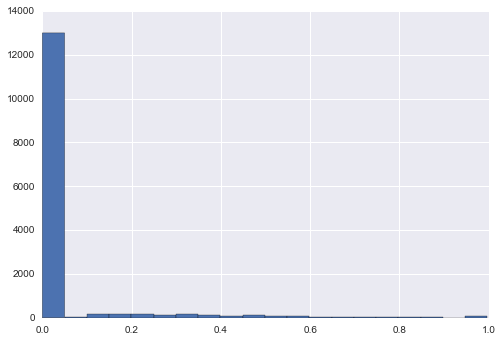

In [108]:
kagSortedDf['col1'].hist(bins=20)
plt.show()

In [127]:
#cleanKagTweetList
list(kagSortedDf[kagSortedDf.col1>0.1].index)
#kagTweets.loc[list(set(kagSortedDf[kagSortedDf.col1>0.1].index))]['text']

[55,
 66,
 67,
 70,
 86,
 89,
 98,
 101,
 107,
 114,
 126,
 137,
 156,
 158,
 159,
 196,
 200,
 201,
 205,
 226,
 232,
 235,
 277,
 282,
 318,
 326,
 334,
 335,
 340,
 344,
 360,
 365,
 372,
 386,
 445,
 450,
 456,
 463,
 479,
 487,
 499,
 509,
 564,
 569,
 573,
 593,
 606,
 610,
 643,
 650,
 652,
 655,
 675,
 700,
 704,
 711,
 715,
 716,
 719,
 764,
 786,
 792,
 796,
 803,
 808,
 833,
 843,
 844,
 847,
 862,
 884,
 899,
 918,
 923,
 928,
 934,
 939,
 960,
 961,
 986,
 990,
 996,
 1008,
 1041,
 1064,
 1070,
 1073,
 1097,
 1098,
 1102,
 1119,
 1121,
 1130,
 1133,
 1135,
 1149,
 1158,
 1166,
 1215,
 1229,
 1263,
 1265,
 1266,
 1269,
 1272,
 1287,
 1294,
 1297,
 1326,
 1331,
 1333,
 1346,
 1350,
 1361,
 1373,
 1419,
 1422,
 1436,
 1468,
 1510,
 1520,
 1527,
 1533,
 1561,
 1570,
 1590,
 1600,
 1621,
 1656,
 1660,
 1673,
 1688,
 1718,
 1719,
 1732,
 1747,
 1760,
 1761,
 1766,
 1767,
 1773,
 1781,
 1796,
 1800,
 1813,
 1816,
 1824,
 1839,
 1847,
 1874,
 1875,
 1879,
 1896,
 1901,
 1904,
 191

In [128]:
#kagSortedDf[(kagSortedDf.col1>0.4) & (kagSortedDf.col1<0.5)]

In [129]:
kagTweets.loc[89]['text']

'@VirginAmerica Why is the site down?  When will it be back up?'

In [84]:
kagCleanArray = np.array(cleanKagTweetList)
#kagCleanArray
srtIdx = list(kagSortedDf[kagSortedDf.col1>0.1].index)
srtTweets = list(kagCleanArray[srtIdx])
topicCloudWords = ' '.join([' '.join(string) for string in srtTweets])

In [107]:
#srtTweets

In [80]:
from wordcloud import WordCloud

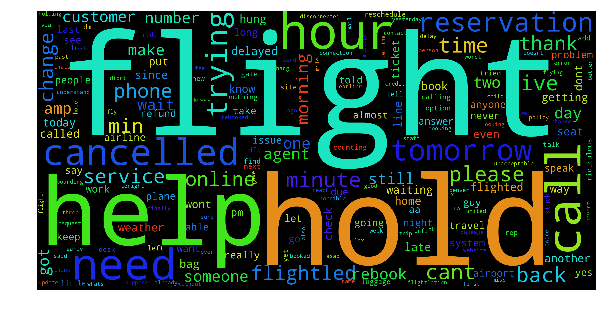

In [88]:
topicCloud = WordCloud(max_font_size=100,scale=8).generate(topicCloudWords)
#topicCloud = WordCloud(max_font_size=100,scale=8).generate(' '.join([' '.join(string) for string in srtTweets]))

fig = plt.figure(figsize=(10,10), dpi=1600)
plt.imshow(topicCloud)
plt.axis("off")
plt.show()

### Parameters I want to get an intuition for
1. What are perplexity metrics?
2. How many documents do I need for this to be effective?
3. How does using a different alpha value change the topics obtained by the model?
4. Does topic number reduce perplexity? Will more topics always reduce perplexity?


In [93]:
#models.ldamulticore.LdaMulticore.log_perplexity(kagLda)
kagLda.log_perplexity(kagCorpus)

-9.3352311417525442

In [110]:
tempLDA = createLDA(kagCorpus, kagDict,myTopics=20)

In [111]:
pyLDAvis.gensim.prepare(tempLDA, kagCorpus, kagDict)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      12.342593        1       1 -0.167412 -0.023112
16      7.595106        1       2 -0.102757 -0.081826
9       6.556064        1       3 -0.053864  0.026497
0       5.960392        1       4 -0.076083 -0.113312
8       5.541048        1       5 -0.049382  0.062970
14      5.492479        1       6 -0.024098  0.070083
1       5.228620        1       7  0.136721 -0.142235
4       5.126752        1       8  0.059396 -0.070064
2       4.507879        1       9 -0.031332 -0.003253
6       4.335051        1      10  0.193753 -0.106785
17      4.271573        1      11 -0.058222 -0.060857
11      4.223480        1      12  0.002392  0.030150
3       4.061831        1      13  0.052400  0.025468
5       3.983982        1      14  0.004033  0.021925
18      3.929081        1      15 -0.068613 -0.028847
19      3.906088        1      16 -0.083709  0.042434
10      3.783042        1      17  0.055068 -0.005059
15      3.509125        1      18  0.032857  0.130090
12      3.312629        1      19  0.113096  0.152488
13      2.333186        1      20  0.065756  0.073245, topic_info=      Category         Freq             Term  Total  loglift  logprob
7674   Default  1048.000000        cancelled   1048  30.0000  30.0000
322    Default   976.000000          service    976  29.0000  29.0000
6725   Default   755.000000              bag    755  28.0000  28.0000
2550   Default   917.000000         customer    917  27.0000  27.0000
7318   Default   601.000000            thank    601  26.0000  26.0000
11646  Default  4494.000000           flight   4494  25.0000  25.0000
1277   Default   502.000000        flightled    502  24.0000  24.0000
3775   Default  1066.000000           thanks   1066  23.0000  23.0000
6426   Default   548.000000             call    548  22.0000  22.0000
8375   Default   555.000000           please    555  21.0000  21.0000
1761   Default   714.000000            plane    714  20.0000  20.0000
10450  Default   216.000000          jetblue    216  19.0000  19.0000
11148  Default   232.000000            worst    232  18.0000  18.0000
139    Default   637.000000             hold    637  17.0000  17.0000
7822   Default   538.000000          airline    538  16.0000  16.0000
6375   Default   243.000000             ever    243  15.0000  15.0000
8870   Default   253.000000               dm    253  14.0000  14.0000
7539   Default  1371.000000              get   1371  13.0000  13.0000
5290   Default   152.000000            fleet    152  12.0000  12.0000
5281   Default   148.000000            fleek    148  11.0000  11.0000
2881   Default   246.000000            email    246  10.0000  10.0000
6385   Default   317.000000            never    317   9.0000   9.0000
8139   Default   423.000000             late    423   8.0000   8.0000
9654   Default   539.000000             gate    539   7.0000   7.0000
4264   Default   305.000000         tomorrow    305   6.0000   6.0000
3163   Default   308.000000          problem    308   5.0000   5.0000
11119  Default   127.000000           follow    127   4.0000   4.0000
4278   Default   223.000000         flighted    223   3.0000   3.0000
4676   Default   519.000000          delayed    519   2.0000   2.0000
6994   Default   306.000000           flying    306   1.0000   1.0000
...        ...          ...              ...    ...      ...      ...
7258   Topic20    36.588606            agent    413   1.4043  -4.3263
7372   Topic20     4.984469           living      9   3.3482  -6.2086
8323   Topic20    14.631926             fine     39   2.5949  -5.4956
8593   Topic20    22.594550           newark     57   2.3905  -5.3205
6457   Topic20     1.997503  #thenewamerican      4   3.7437  -6.6241
8209   Topic20     9.258771         pleasant     14   3.0659  -6.0492
5179   Topic20    22.141076          flightr    155   1.7151  -4.9956
6540   Topic20     3.257620     indiana

### Could be nice to see which airline has the most trouble or gets the most positive responses

In [99]:
#get unique airlines in dataset
np.unique(kagTweets['airline'])

array(['American', 'Delta', 'Southwest', 'US Airways', 'United',
       'Virgin America'], dtype=object)

In [101]:
tempLDA = createLDA(kagCorpus, kagDict,myPasses=1,myIterations=1)

In [103]:
tempLDA.log_perplexity(kagCorpus)

-35.165851361464973

In [105]:
myNumTopics = [5,10,15,20,30,40,50,60,70,80,90,100,125,150,175,200]

In [106]:
for i in myNumTopics:
    tempLDA = createLDA(kagCorpus, kagDict,myPasses=10,myIterations=50,myTopics=i)
    print tempLDA.log_perplexity(kagCorpus)

-8.59480084875
-8.78183116319
-8.88128765747
-8.98503369168
-9.1106256775
-9.25185504989
-9.33457901644
-9.4047096351
-9.45487341335
-9.52136222915
-9.58958047556
-9.5906977889
-9.72553756621
-9.80253888669
-9.84237057044
-9.83243885693


In [ ]:
kagLda = createLDA(kagCorpus, kagDict)

In [104]:
kagLda.num_topics

50

In [ ]:
>>> import numpy as np
>>> a = np.array([-2, 1, 5, 3, 8, 5, 6])
>>> b = [1, 2, 5]
>>> print list(a[b])
[1, 5, 5]

In [ ]:
#kagDf.iloc[translateIdx].reset_index()

In [ ]:
#np.sort(kagDf.loc[39,])
kagDf.sort_values()

# Try to implement bigrams into analysis

In [ ]:
from gensim.models.phrases import Phrases
from gensim import similarities


In [ ]:
def getBigram(myTweetlist):
    bigram = Phrases(tweetList)
    return [bigram[tweet] for tweet in myTweetlist]

In [ ]:
cleanTweets = filterTweetList(tweets['message'])
bigramTweetList = getBigram(cleanTweets)

In [ ]:
bigramDict = makeDict(bigramTweetList)
bigramCorpus = makeCorpus(bigramTweetList)

#bigramDict = bigramDict.compactify()
bigramLda = createLDA(myCorpus = bigramCorpus, myDictionary = bigramDict)
#dictionary.

#createLDA()

In [ ]:
bigramDict = makeDict(bigramTweetList)
bigramLda = createLDA(myCorpus = bigramCorpus, myDictionary = bigramDict)

In [ ]:
#bigramDict = bigramDict.compactify()

In [ ]:
pyLDAvis.gensim.prepare(bigramLda, bigramCorpus, bigramDict)

# Code for single tweet validation 

In [ ]:
# First, build index in order to query the model

myIndex = MatrixSimilarity(lda[myCorpus]) # transform corpus to LSI space and index it
sims = myIndex[myVec_lda] # perform a similarity query against the corpus
sims = sorted(enumerate(sims), key=lambda item: -item[1])



In [ ]:
# Function for tweet validation

def validateTweet(testTweet, myDict=myDict, myLda=lda ):
    myDoc = ' '.join([prepText(word) for word in testTweet.split() if prepText(word) is not None])    
    myVec_bow = myDict.doc2bow(myDoc.lower().split())
    myVec_lda = myLda[myVec_bow]
    sims = myIndex[myVec_lda] # perform a similarity query against the corpus
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    matchIdx = [i[0] for i in sims[1:300]]
    topHandlers = list(tweets.iloc[matchIdx]['fromHandler'])
    return topHandlers

validateTweet("@JennyMcCarthy #dsf I wrote a children's book about bullying. It's on Amazon. Want to help promote it?!? The Bully's Nightmare")

In [ ]:
#Trial tweet for validation

myDoc = '@saracozart No need to continue the struggle. Were here and we can help. DM us for info about switching. http://spr.ly/6017BkrjL* OMV'
myDocOrig = "@ATT @ATTCares I have been on hold for one hour & 11minutes. This is a little excessive. Worst customer service I've ever received."
myDoc = ' '.join([prepText(word) for word in myDoc.split() if prepText(word) is not None])
print myDoc                
myVec_bow = myDict.doc2bow(myDoc.lower().split())
#myVec_bow = dictionary.doc2bow(myDoc.lower().split())
myVec_lda = lda[myVec_bow]
print(myVec_lda)

In [ ]:
# Find the best 300 tweet matches
matchIdx = [i[0] for i in sims[1:300]]
topHandlers = list(tweets.iloc[matchIdx]['fromHandler'])

In [ ]:
#>>> sims = myIndex[myVec_lda] # perform a similarity query against the corpus
#>>> print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples

In [ ]:
#>>> sims = sorted(enumerate(sims), key=lambda item: -item[1])
#>>> print(sims) # print sorted (document number, similarity score) 2-tuples

In [ ]:
# Find the best 300 tweet matches
#matchIdx = [i[0] for i in sims[1:300]]


In [ ]:
topHandlerCounts = Counter(topHandlers)
sortedHandlers = sorted(topHandlerCounts.items(), key=lambda x: x[1],reverse=True)[0:5]

handlerNames = [handler[0] for handler in sortedHandlers]
handlerCounts = [handler[1] for handler in sortedHandlers]

indexes = np.arange(len(handlerNames))
width = 0.9
plt.bar(indexes, handlerCounts, width)
plt.xticks(indexes + width * 0.5, handlerNames)
plt.ylabel('Frequency',fontsize=16)

# Plot histogram using matplotlib bar().
#indexes = np.arange(len(author_names))
#width = 0.7
#plt.bar(indexes, author_counts, width)
#plt.xticks(indexes + width * 0.5, author_names)
plt.show()
#

In [ ]:
#Trial tweet for validation LSI

myDoc = '@saracozart No need to continue the struggle. Were here and we can help. DM us for info about switching. http://spr.ly/6017BkrjL* OMV'
myDocOrig = "@ATT @ATTCares I have been on hold for one hour & 11minutes. This is a little excessive. Worst customer service I've ever received."
myDoc = ' '.join([prepText(word) for word in myDoc.split() if prepText(word) is not None])
print myDoc                
myVec_bow = myDict.doc2bow(myDoc.lower().split())
#myVec_bow = dictionary.doc2bow(myDoc.lower().split())
myVec_lsi = lsi[myVec_bow]
print(myVec_lsi)

In [ ]:
# How would I get the topic distribution for the top tweets?

In [ ]:
simsLsi = myIndex[myVec_lsi] # perform a similarity query against the corpus
simsLsi = sorted(enumerate(simsLsi), key=lambda item: -item[1])
matchIdx = [i[0] for i in simsLsi[1:300]]
topHandlers = list(tweets.iloc[matchIdx]['fromHandler'])

In [ ]:
topHandlers

In [ ]:
#83287 words
# 50 topics
myIndex.index.shape

In [ ]:
# All 80k tweets for 4th topic
myIndex.index[:,4]

In [ ]:
# All 50 topics for 4th tweet
myIndex.index[4,:]

In [ ]:
#lda.print_topic(49)
lda.show_topic(49)

In [ ]:
tweets.iloc[matchIdx][1:300]

In [ ]:
sims[1:300]

In [ ]:
myDoc = '@saracozart No need to continue the struggle. Were here and we can help. DM us for info about switching. http://spr.ly/6017BkrjL* OMV'

>>> doc = "Human computer interaction"
>>> vec_bow = dictionary.doc2bow(doc.lower().split())
>>> vec_lsi = lsi[vec_bow] # convert the query to LSI space
>>> print(vec_lsi)

In [ ]:
>>> index = similarities.MatrixSimilarity(lsi[corpus]) # transform corpus to LSI space and index it

In [ ]:
>>> sims = index[vec_lsi] # perform a similarity query against the corpus
>>> print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples

In [ ]:
>>> sims = sorted(enumerate(sims), key=lambda item: -item[1])
>>> print(sims) # print sorted (document number, similarity score) 2-tuples

In [ ]:
tweets.iloc[35536]['message']

In [ ]:
bigram = Phrases(tweetList)

In [ ]:
#from gensim.models import Phrases


#print bigram[tweetList[152:153]]

test     = bigram[tweetList[152:153]]
#testDict = Phrases(tweetList[152:153])

testDict =  corpora.Dictionary(test)
#print bigram[tweetList[152:153]]
print test.corpus
#phraseTest = Phrases(tweetList[152:153])


In [ ]:
for i in range(152,200):
    print bigram[tweetList[i]]

In [ ]:
#lda

In [ ]:
tfidf_lda= models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=8, passes = 10,
    iterations=50)

In [ ]:
topTopicsTfIdf = tfidf_lda.top_topics(corpus_tfidf)

In [ ]:
#topTopicsTfIdf
#pyLDAvis.gensim.prepare(tfidf_lda, corpus_tfidf, dictionary)

In [ ]:
frq = nltk.FreqDist(tweetList[3])

In [ ]:
polstops = [w[0] for w in frq.most_common(int(0.3*len(frq)))]
polstops

In [ ]:
frq.most_common(int(0.3*len(frq)))

In [ ]:
[w[0] for w in frq.most_common(int(0.1*len(frq)))]

In [ ]:
[word for word in tweetList[3] if word not in polstops]

In [ ]:
secTweetList = [[word for word in s if word not in polstops] for s in speeches]    

In [ ]:
for i in tweets['message']:
    if 'xi ' in i:
        print i

#'Just' in tweets['message'].iloc[0]

In [ ]:
iter

In [ ]:
tweets

# Try to get count vectorizer for bag of words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
vectorizer = CountVectorizer(min_df=1)


In [ ]:
X = vectorizer.fit_transform(verTweets['message'])

In [ ]:
#list(verTweets['message'])

# Trying gensim

In [ ]:
from gensim import corpora, models, similarities
from gensim.models import ldamodel

In [ ]:
list(verTweets['message'])

In [ ]:
>>> # remove common words and tokenize
documents = list(verTweets['message'])

>>> stoplist = set('for a of the and to in'.split())
>>> texts = [[word for word in document.lower().split() if word not in stoplist]
>>>          for document in documents]
>>>
>>> # remove words that appear only once
>>> from collections import defaultdict
>>> frequency = defaultdict(int)
>>> for text in texts:
>>>     for token in text:
>>>         frequency[token] += 1
>>>
>>> texts = [[token for token in text if frequency[token] > 1]
>>>          for text in texts]
>>>
>>> from pprint import pprint   # pretty-printer
#>>> pprint(texts)

In [ ]:
>>> dictionary = corpora.Dictionary(texts)
>>> dictionary.save('/tmp/deerwester.dict') # store the dictionary, for future reference
>>> print(dictionary)

In [ ]:
#lda = ldamodel.LdaModel(list(verTweets['message']), num_topics=10)

In [ ]:
ldamodel.

In [ ]:
print 'Representative duplicate tweet: \n'
print tweets.iloc[45185]['message']


In [ ]:
# Count the number of occurences of the above tweet

print tweets.iloc[45194]['message']
print
msg1 = 'I always confuse @JetBlue crew members when I use this bag\xe2\x80\xa6 \xe2\x80\x9cNo I don\xe2\x80\x99t work for JB\xe2\x80\xa6 ish\xe2\x80\xa6\xe2\x80\x9d\nWheels up to Boston! https://t.co/61fKRnYNpK'
dups1 = tweets[tweets.message == msg1]
print "number of dups: " + str(len(dups1)) + '\n'
dups1.head()


In [ ]:
def dupCounter(msg):
    """Count the number of repeated tweets that match a given string"""
    dups = tweets[tweets.message == msg]
    dups.head()
    return len(dups)

dupCounter(tweets.iloc[45194]['message'])    

In [ ]:
# Get all unique tweets

uniqTweets = list(set(tweets['message']))

print 'number of unique tweets: ' + str(len(uniqTweets))

# Only 136 unique tweets. Something looks wrong.

In [ ]:
# For each unique tweet, count the number of duplicate tweets 
dupCounts = []

for i in uniqTweets:
    dupCounts.append(dupCounter(i))


In [ ]:
#Plot the redundancy of tweets

plt.bar([i for i in range(len(dupCounts))],dupCounts)
plt.ylabel('Tweet redundancy',fontsize=16)
#plt.title('duplicate tweets',fontsize=24)
#plt.xlabel('unique tweets')
#plt.bar([i for i in range(10)],range(10))

plt.ylim([0,7000])

plt.show()

# Preliminary tweet cleaning

In [ ]:
# To build a list of tweets coming from and to JetBlue

toJetTweets   = list(set(tweets.loc[tweets.toHandler == '@JetBlue','message']))
fromJetTweets = list(set(tweets.loc[tweets.toHandler != '@JetBlue','message']))

In [ ]:
#[i.lower() for i in ' '.join(toJetTweets).split()]

In [ ]:
wordList = [i.lower() for i in ' '.join(uniqTweets).split()]
wordList = [i for i in wordList if i not in stopwords.words('english')]
#filtWords = [i for i in skillList.split() if i not in stopwords.words('english')]

In [ ]:
#wordList

In [ ]:
freqWord = Counter(wordList).most_common(10)

In [ ]:
def getFreqWords(tweetList,topWordThresh=10):
    wordList = [i.lower() for i in ' '.join(tweetList).split()]
    wordList = [i for i in wordList if i not in stopwords.words('english')]
    return Counter(wordList).most_common(topWordThresh)
getFreqWords(uniqTweets)

In [ ]:
uniqTweets
toJetTweets

In [ ]:
def plotFreqWords(freqWords):
    fig = plt.figure(figsize=(5,4), dpi=1600)
    ax = fig.add_subplot(111)

    plt.bar([i for i in range(10)],[i[1] for i in freqWords],alpha=0.7)
    plt.xticks([i+0.5  for i in range(10)], [i[0] for i in freqWords], rotation='vertical')

    ax.set_xticklabels([i[0] for i in freqWords],rotation=45,ha='right')
    ax.set_ylim(0,25)
    ax.set_ylabel('Word Frequency',fontsize=16)

    plt.show()
    
plotFreqWords(getFreqWords(fromJetTweets))

In [ ]:
fig = plt.figure(figsize=(5,4), dpi=1600)
ax = fig.add_subplot(111)


plt.bar([i for i in range(10)],[i[1] for i in freqWord],alpha=0.7)
plt.xticks([i+0.5  for i in range(10)], [i[0] for i in freqWord], rotation='vertical')

ax.set_xticklabels([i[0] for i in freqWord],rotation=45,ha='right')
ax.set_ylim(0,25)
ax.set_ylabel('Word Frequency',fontsize=16)

plt.show()

In [ ]:
for i in uniqTweets:
    if 'thanks' in i:
        print i
    

In [ ]:
x = [1, 2, 3, 4]
y = [1, 4, 9, 6]
labels = ['Frogs', 'Hogs', 'Bogs', 'Slogs']

plt.plot(x, y, 'ro')
# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(x, labels, rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

In [ ]:
[len(freqWord)]

In [ ]:
sorted(wordList.items(), key=operator.itemgetter(1),reverse=True)

In [ ]:
sortedFreq = sorted(wordList.items(), key=operator.itemgetter(1),reverse=True)

In [ ]:
dict(sortedFreq)

In [ ]:
#plt.plot([i for i in range(len(sortedFreq))],sortedFreq)

In [ ]:
print tweets.iloc[45185]['message']

In [ ]:
print tweets.iloc[45229]['message']
tweets.iloc[45229]['message']

In [ ]:
tknzr = TweetTokenizer()

In [ ]:
tknzr.tokenize(tweets.iloc[45229]['message'])

In [ ]:
len(list(set(tweets.message)))

In [ ]:
[i for i in wordList if i.startswith('#')]
[i for i in wordList if i.startswith('@')]

In [ ]:
print uniqTweets[0]
tknzr.tokenize(uniqTweets[0])

# Some sklearn stuff

In [ ]:
from sklearn.feature_extraction import DictVectorizer

In [ ]:
measurements = [
...     {'city': 'Dubai', 'temperature': 33.},
...     {'city': 'London', 'temperature': 12.},
...     {'city': 'San Fransisco', 'temperature': 18.},
... ]

In [ ]:
vec = DictVectorizer()

In [ ]:
vec.fit_transform(measurements).toarray()

In [ ]:
vec.get_feature_names()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer(min_df=1)
vectorizer             

In [ ]:
>>> corpus = [
...     'This is the first document.',
...     'This is the second second document.',
...     'And the third one.',
...     'Is this the first document?',
... ]
>>> X = vectorizer.fit_transform(corpus)
>>> X             

In [ ]:
>>> analyze = vectorizer.build_analyzer()
>>> analyze("This is a text document to analyze.") == (
...     ['this', 'is', 'text', 'document', 'to', 'analyze'])


In [ ]:
>>> vectorizer.get_feature_names() == (
...     ['and', 'document', 'first', 'is', 'one',
...      'second', 'the', 'third', 'this'])
True

>>> X.toarray()           

In [ ]:
>>> vectorizer.vocabulary_.get('document')

In [ ]:
>>> vectorizer.transform(['Something completely new.']).toarray()

In [ ]:
>>> bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
...                                     token_pattern=r'\b\w+\b', min_df=1)
>>> analyze = bigram_vectorizer.build_analyzer()
>>> analyze('Bi-grams are cool!') == (
...     ['bi', 'grams', 'are', 'cool', 'bi grams', 'grams are', 'are cool'])

In [ ]:
>>> X_2 = bigram_vectorizer.fit_transform(corpus).toarray()
>>> X_2

In [ ]:
>>> feature_index = bigram_vectorizer.vocabulary_.get('is this')
>>> X_2[:, feature_index]     

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


In [ ]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

In [ ]:
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

In [ ]:
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

In [ ]:
dataset.keys()
#dataset['DESCR']

In [ ]:
use_hashing = True
use_idf = True
n_features = 10000

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if use_hashing:
    if use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=n_features,
                                   stop_words='english', non_negative=True,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=n_features,
                                       stop_words='english',
                                       non_negative=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=use_idf)
X = vectorizer.fit_transform(dataset.data)


In [ ]:
n_components = 0
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


In [ ]:
###############################################################################
# Do the actual clustering

minibatchBool = True
verboseBool = False

if minibatchBool:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=verboseBool)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()

In [ ]:
use_hashing = False

if not use_hashing:
    print("Top terms per cluster:")

    if n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

In [ ]:
dbname = 'tweets'
username = 'Peter'

In [ ]:
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print engine.url

In [ ]:
# Needed to use `createdb Peter` on bash terminal before psql would work
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

In [ ]:
tweets.to_sql('tweets_table', engine, if_exists='replace')

In [ ]:
# Create connection to database
con = psycopg2.connect(database = dbname, user = username)

In [ ]:
# query:
#sql_query = """
#SELECT * FROM tweets_table;
#"""

#select id, account, message from tweets_table limit 20;
#select * from tweets_table limit 20; 

sql_query = """
select id, account, message, tweet_id from tweets_table limit 5;
"""

def sqlPandasQuery(myQuery):
    tweets_from_sql = pd.read_sql_query(myQuery,con)
    return tweets_from_sql

sqlPandasQuery(sql_query)

In [ ]:
### can I do a SQL query to find conversations of given length?


In [ ]:
tweets.to_sql('tweets_table', engine, if_exists='replace')

In [ ]:
# Create connection to database
con = psycopg2.connect(database = dbname, user = username)

In [ ]:
# query:
#sql_query = """
#SELECT * FROM tweets_table;
#"""

#select id, account, message from tweets_table limit 20;
#select * from tweets_table limit 20; 

sql_query = """
select id, account, message, tweet_id from tweets_table limit 5;
"""

def sqlPandasQuery(myQuery):
    tweets_from_sql = pd.read_sql_query(myQuery,con)
    return tweets_from_sql

sqlPandasQuery(sql_query)

In [ ]:
### can I do a SQL query to find conversations of given length?